# Regularization

When fitting a linear regression with multiple features $x=(x^1,x^2,...,x^n)$ 
$$
y\sim w^T x
$$
the model might become complex and susceptible to overfitting. Complexity often comes with coefficients $w$ growing large in absolute values.

One way to reduce complexity is to penalize regression for the magnitude of the coefficients $w=(w^1,w^2,...,w^n)$, which can be measured by
$$
||w||_1=\sum\limits_j |w^j|
$$
or by 
$$
||w||_2^2=\sum\limits_j (w^j)^2
$$
So instead of simply minimizing 
$$
RSS(w)=\sum\limits_j (y_j-w^T x_j)^2
$$
where $x_j, y_j$ are observations for regressors and output variable, we minimize
$$
RSS(w)+\lambda ||w||_2^2=RSS(w)+\lambda \sum\limits_j (w^j)^2\to\min\hspace{10ex}(Ridge)
$$
or
$$
RSS(w)+\lambda ||w||_1=RSS(w)+\lambda \sum\limits_j \left|w^j\right|\to\min\hspace{10ex}(Lasso)
$$

The first model is known as Ridge, the second - as Lasso (least absolute shrinkage and selection operator) regularized regression.

Both Ridge and Lasso could be shown to be equivalent to a constrained minimization of $RSS$:

$$
RSS(w)\to min, \ ||w||_p\leq \alpha,
$$

with $p=1,2$ respectively, although analytic relation between constants $\alpha$ and $\lambda$ is somewhat nontrivial. In practice however the choice of $\lambda$ or $\alpha$ is usually empirical anyway, so both regularized or constrained forms of the optimization problem are equally applicable.

Optimization problems (Ridge) and (Lasso) tend to minimize $RSS$ at the same time penalizing the regression for having $||w||$ too large (regularization) which often leads to the model complexity through multiple regressors with large coefficients canceling effect of each other. So in a sense Lasso and Ridge are trying to avoid this situation, looking for relatively simple "regular" models with best possible fit. 

** NOTICE ** As the order of magnitude of $w^j$ is directly related to the scale of the regressors, it is practical to rescale them (e.g. by standardizing) to make sure the $w^j$ are comparable in scale. Otherwise penalization terms directly mixing components $w^j$ of different, sometimes incomparable, scale do not make too much sense.

From Bayesian standpoint (for those familiar with Bayesian inference) Lasso and Ridge simply perform the regression with the prior belief that all the components of the $w$ are limited through the fixed variance of the priors. Such a belief affects the final outcome of the model making solutions with large $||w||$ to be particularly unlikely.

This helps Ridge and Lasso to fight overfitting also dealing with multicollinearity of regressors to some extent, preventing from learning noise through particularly complex "unnatural" combinations of the regressors.

Ridge regression admits solution in the closed form (consider partial derivatives of the objective function with respect to $w_j$):

$$
\hat{w}=(X^T X+\lambda I)^{-1}X^T Y, \hspace{5ex}(Ridge\ solution)
$$

where $I$ is the identity $n\times n$ matrix, while $n$ being the number of regressors. The formulae (Ridge solution) shows that the Ridge regression can in theory deal with the case of multicollinearity, when the matrix $X^T X$ is singular and OLS estimate does not exist.

Lasso does not admit solution in the closed form and requires numerical methods (like subgradient methods) to be fit. 
Lasso however has an advantage of being often able to completely eliminate impact of certain irrelevant regressors setting the corresponding slope coefficients to zero.  

### Validation and cross-validation

A good way to evaluate the model is to use a test set separate from the training sample to estimate the model performance. Additionally if the model depends on the certain parameters (like $\alpha,\lambda$ for Lasso/Ridge) which are not supposed to be fit during the training phase, a separate validation sample could be used for the selection of model parameters (we pick up those which optimize model performance over the validation set). Usually test and validation sets are got as subsamples (often random) of the available dataset, while the remaining data is used as the training sample. 

But often the available dataset is small enough, so splitting into into even smaller traning, validation and test sets could have negative impact on the model training leading to noisy and unreliable models. In such cases cross-validation is often applied, performing not one but several random splits of the sample with further averaging of the model performance scores. 

## Choice of $\lambda$ or $\alpha$. Model validation.

In both - constrained and regularized forms - the parameter $\alpha$ or $\lambda$ of Lasso/Ridge regression is somewhat arbitrary and can take any value from $0$ to $+\infty$. Small values of $\lambda$ or high values of $\alpha$ lead to the result close to OLS (identical to it is $\lambda=0$ or $\alpha=+\infty$), while large $\lambda$ or small $\alpha$ tend to overemphasize the impact of regularization over the fit itself. There is no single best way of choosing the value of the regularization parameter - what is usually suggested is to fit it by evaluating the model for different values of the parameter over the separate validation set and picking up the value for which the validation performance is the best one. As for the performance metric one can use RSS or, equivalently, R2.

## Example 1. Regularization with artifical data

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import linear_model
import matplotlib.pylab as plt
import math
import seaborn as sbn
%matplotlib inline

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
data3=pd.read_csv("data/example3.csv")
print(len(data3))
data3.head()

50


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x20,x21,x22,x23,x24,x25,x26,x27,x28,Y
0,26,22.415927,1.481339,9.634145,-15.316976,3.707672,44.960785,27.480018,48.835505,5.382629,...,42.863416,39,26,95,83,16,21,66,87,17.023843
1,68,59.433665,14.979972,22.192560,-35.872848,12.682355,117.701114,66.681792,124.983058,18.150923,...,101.877161,45,52,24,42,97,65,47,94,73.075316
2,45,39.162046,7.587863,15.315333,-24.616061,7.767647,77.867124,45.214154,83.283207,11.158762,...,69.560110,53,64,31,31,64,74,19,55,34.872741
3,91,79.705283,22.372081,29.069787,-47.129635,17.597062,157.535104,88.149430,166.682908,25.143084,...,134.194211,90,50,49,30,95,65,80,77,64.479635
4,15,12.720805,-2.054018,6.345036,-9.933295,1.357160,25.909746,17.212886,28.892098,2.038551,...,27.407435,9,49,73,23,76,37,44,55,19.937208


In [3]:
#standardise the data
#for c in data3.columns:
#    data3[c]=(data3[c]-data3[c].mean())/data3[c].std()

In [4]:
result = smf.ols(formula = 'Y ~ '+ '+'.join(data3.columns[1:-1]), data = data3).fit()
OLS_coef=result.params
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     6.953
Date:                Wed, 26 Sep 2018   Prob (F-statistic):           1.22e-05
Time:                        20:13:39   Log-Likelihood:                -161.31
No. Observations:                  50   AIC:                             380.6
Df Residuals:                      21   BIC:                             436.1
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -1.438e+10    7.4e+10     -0.194      0.8

#### Question: Maybe the coefficients of x1 to x20 are too big? Any guesses?

In [5]:
#indeed they are almost completely correlated
data3.corr()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x20,x21,x22,x23,x24,x25,x26,x27,x28,Y
x0,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.320502,-0.164480,0.078618,-0.014599,0.047252,-0.113727,-0.008182,-0.003293,0.867898
x1,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.320502,-0.164480,0.078618,-0.014599,0.047252,-0.113727,-0.008182,-0.003293,0.867898
x2,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.320502,-0.164480,0.078618,-0.014599,0.047252,-0.113727,-0.008182,-0.003293,0.867898
x3,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.320502,-0.164480,0.078618,-0.014599,0.047252,-0.113727,-0.008182,-0.003293,0.867898
x4,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.320502,0.164480,-0.078618,0.014599,-0.047252,0.113727,0.008182,0.003293,-0.867898
x5,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.320502,-0.164480,0.078618,-0.014599,0.047252,-0.113727,-0.008182,-0.003293,0.867898
x6,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.320502,-0.164480,0.078618,-0.014599,0.047252,-0.113727,-0.008182,-0.003293,0.867898
x7,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.320502,-0.164480,0.078618,-0.014599,0.047252,-0.113727,-0.008182,-0.003293,0.867898
x8,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.320502,-0.164480,0.078618,-0.014599,0.047252,-0.113727,-0.008182,-0.003293,0.867898
x9,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.320502,-0.164480,0.078618,-0.014599,0.047252,-0.113727,-0.008182,-0.003293,0.867898


Let's evaluate if this OLS model for such a dataset is actually generalizeable. For that purpose let us divide the dataset into training set and the test set.

In [6]:
np.random.seed(2016)
Shuffle = np.random.permutation(len(data3))
train = data3.take(Shuffle)[:30]
test = data3.take(Shuffle)[30:]

In [7]:
# An anonymous function that returns a regression model based on a given features for future usage
Regress = lambda feature: smf.ols(formula = 'Y ~ %s'%feature, data = train).fit()

# For displaying R^2 and linear model summary
def modelEval(lm, key = 'Y'):
    lmy = lm.predict(test)
    y_err = lmy - test[key]
    y_norm = test[key]-np.mean(test[key])
    return 1-y_err.dot(y_err)/y_norm.dot(y_norm)  # R2 w.r.t. test set

In [8]:
result = smf.ols(formula = 'Y ~ '+ '+'.join(data3.columns[:-1]), data = train).fit()
print('In sample R-squared: %f'%result.rsquared)
print('Out of sample R-squared: %f'%modelEval(result))
print('Fitted coefficients:')
print result.params

In sample R-squared: 1.000000
Out of sample R-squared: -85.506430
Fitted coefficients:
Intercept   -5.122806e+10
x0           5.105390e+10
x1          -8.762946e+09
x2           2.375593e+09
x3           2.051503e+10
x4           1.855645e+10
x5           2.563073e+09
x6          -3.846871e+09
x7          -1.731840e+09
x8          -3.627330e+09
x9           8.760216e+09
x10          3.578956e+09
x11          3.279107e+09
x12          1.251933e+09
x13         -3.021845e+08
x14          1.697260e+10
x15         -2.260147e+10
x16         -1.826999e+10
x17          2.268399e+10
x18         -2.556983e+09
x19          4.517150e+09
x20          2.076919e+09
x21         -6.042262e-01
x22         -7.705317e-01
x23          6.603386e-01
x24         -4.361242e-01
x25          5.270271e-01
x26         -1.136574e+00
x27         -2.998373e-01
x28         -1.032812e+00
dtype: float64


So while OLS reached almost perfect IS performance over the training set (which is not too suprizing as one would expect 29 regressors to be able to learn nearly all the infromation from the sample of 30 observations) it's generalizeability is quite poor (OS R2 goes way below zero). So there is clearly an overfitting problem. Let's track its dynamics adding variables to the regression one by one.

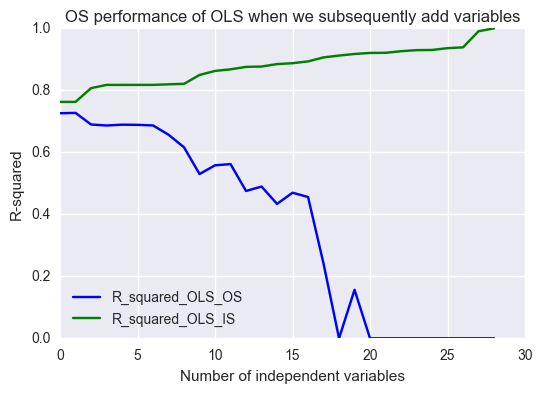

In [9]:
Number_variables=range(len(data3.columns[:-1]))
OLS_R_2_OS_F=[]
OLS_R_2_IS_F=[]

for i in Number_variables:
    
    lm = smf.ols(formula = 'Y ~ '+ '+'.join(data3.columns[:i+1]), data = train).fit()
    R2 = modelEval(lm)
    OLS_R_2_IS_F.append(lm.rsquared)
    OLS_R_2_OS_F.append(R2 if R2 > 0 else 0)

plt.title('OS performance of OLS when we subsequently add variables')
plt.plot(Number_variables,OLS_R_2_OS_F,'b',label='R_squared_OLS_OS')
plt.plot(Number_variables,OLS_R_2_IS_F,'g',label='R_squared_OLS_IS')
plt.legend(loc='lower left')
plt.xlabel('Number of independent variables')
plt.ylabel('R-squared')
plt.show()

As we see OS OLS R2 is pretty different for IS R2 and the difference starts to grow especially rapidly after more than $15$ variables are added, so there is clearly a major overfitting problem with OLS at that point. Let's see if Lasso/Ridge are able to fix this issue.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data3.ix[:,:-1],
                                    data3.ix[:,-1], test_size = 0.4, random_state = 200)

In [11]:
Ridge=linear_model.Ridge(fit_intercept=True, alpha=1) #try Ridge with an arbitrary regularization parameter alpha=1

Ridge.fit(X_train,y_train)
# In the sample:
p_IS=Ridge.predict(X_train)
err_IS=p_IS-y_train
R_2_IS_Ridge=1-np.var(err_IS)/np.var(y_train)
print("The R-squared we found for IS Ridge is: {0}".format(R_2_IS_Ridge))

Ridge_coef=Ridge.coef_

#Out of sample
p_OS=Ridge.predict(X_test)
err_OS=p_OS-y_test
R_2_OS_Ridge=1-np.var(err_OS)/np.var(y_test)
print("The R-squared we found for OS Ridge is: {0}".format(R_2_OS_Ridge))

The R-squared we found for IS Ridge is: 0.761228474634
The R-squared we found for OS Ridge is: 0.737554781378


So even with a pretty arbitrary choice of $\alpha$ Ridge works pretty well, mostly fixing the overfitting issue. Let's see if one can do better with a more sophisticated choice - for that purpose further split the former training set into training and validation, so that for each lambda the model is being trained over the smaller training sample and optimal lambda is selected based on the model performance over the validation set. Then final result is evaluated over the test set as before.

#### Find the optimal Lambda(Alpha). 

In [12]:
#Find the Alpha and report best test performance for Ridge/Lasso.
def Regularization_fit_alpha(model,X_train,y_train,alphas,p=0.4,Graph=False, logl=False):
    #model = 1-Ridge, 2-Lasso
    #lambdas: a list of lambda values to try
    #p: ratio of the validation sample size / total training size
    #Graph: plot the graph of R^2 values for different lambda

    R_2_OS=[]
    X_train0, X_valid, y_train0, y_valid = train_test_split(X_train,
                                    y_train, test_size = 0.4, random_state = 200)

    if model==1:
        RM = lambda a: linear_model.Ridge(fit_intercept=True, alpha=a)
        model_label='Ridge'
    else:
        RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
        model_label='Lasso'
    
    best_R2 = -1
    best_alpha = alphas[0]
    
    for i in alphas:
        lm = RM(i)
        lm.fit(X_train0,y_train0)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample 
        err_OS=y_predict-y_valid
        R_2_OS_=1-np.var(err_OS)/np.var(y_valid)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2:
            best_R2 = R_2_OS_
            best_alpha = i
    
    if Graph==True:
        plt.title('OS-R-squared for different Alpha')
        if logl:
            plt.xlabel('ln(Alpha)')
            l=np.log(alphas)
            bl=np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l=alphas
            bl=best_alpha
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()
    
    return best_alpha

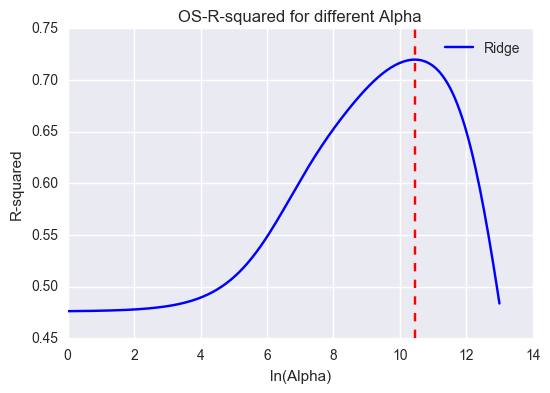

Optimal alpha for Ridge=34622.5785175


In [14]:
#select best lambda for Ridge
alphas = np.exp(np.linspace(0,13,200))
alpha_r_optimal=Regularization_fit_alpha(1,X_train,y_train,alphas,p=0.4,Graph=True,logl=True)
print('Optimal alpha for Ridge={0}'.format(alpha_r_optimal))

In [15]:
Ridge = linear_model.Ridge(fit_intercept=True,alpha=lambda_r_optimal) #try Ridge with a selected regularization parameter lambda

Ridge.fit(X_train,y_train)
# In the sample:
p_IS=Ridge.predict(X_train)
err_IS=p_IS-y_train
R_2_IS_Ridge=1-np.var(err_IS)/np.var(y_train)
print("The R-squared we found for IS Ridge is: {0}".format(R_2_IS_Ridge))

Ridge_coef=Ridge.coef_
#Out of sample
p_OS=Ridge.predict(X_test)
err_OS=p_OS-y_test
R_2_OS_Ridge=1-np.var(err_OS)/np.var(y_test)
print("The R-squared we found for OS Ridge is: {0}".format(R_2_OS_Ridge))

NameError: name 'lambda_r_optimal' is not defined

In [16]:
Ridge_coef

array([ 0.03325889,  0.02931367,  0.01068939,  0.00994482, -0.01627794,
        0.00710685,  0.05760262,  0.03104313,  0.06029923,  0.01011079,
       -0.02428685,  0.01295104, -0.05088002, -0.00380681, -0.01177752,
        0.03115405, -0.0014785 , -0.01282287, -0.05879311,  0.01025099,
        0.04673109, -0.07335555,  0.07571824, -0.01360881,  0.04778351,
        0.04765776,  0.0427822 , -0.05288428,  0.03971198])

#### Lasso. 

In [17]:
Lasso=linear_model.Lasso(fit_intercept=True,alpha=1)
#try Lasso with an arbirtary regularization parameter alpha

Lasso.fit(X_train,y_train)
# In the sample:
p_IS=Lasso.predict(X_train)
err_IS=p_IS-y_train
R_2_IS_Lasso=1-np.var(err_IS)/np.var(y_train)
print("The R-squared we found for IS Lasso is: {0}".format(R_2_IS_Ridge))

Lasso_coef=Lasso.coef_
#Out of sample
p_OS=Lasso.predict(X_test)
err_OS=p_OS-y_test
R_2_OS_Lasso=1-np.var(err_OS)/np.var(y_test)
print("The R-squared we found for OS Lasso is: {0}".format(R_2_OS_Lasso))

The R-squared we found for IS Lasso is: 0.761228474634
The R-squared we found for OS Lasso is: 0.742525885408


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


#### Picking optimal alpha for Lasso model 

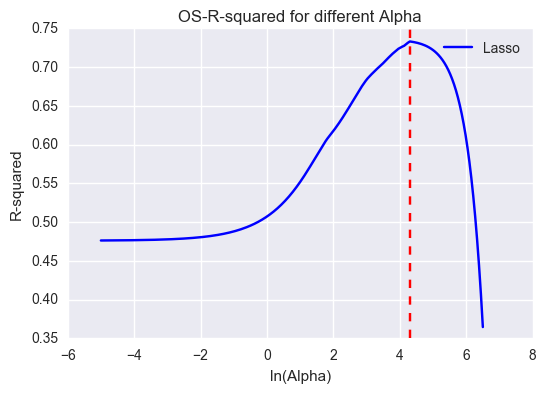

Optimal lambda for Lasso=73.996670615


In [18]:
#select lambdas for Lasso 
alphas=np.exp(np.linspace(-5,6.5,200))
alpha_l_optimal=Regularization_fit_alpha(2,X_train,y_train,alphas,p=0.4,Graph=True,logl=True)
print('Optimal lambda for Lasso={0}'.format(alpha_l_optimal))

In [19]:
Lasso=linear_model.Lasso(fit_intercept=True,alpha=alpha_l_optimal)
#try Ridge with a selected regularization parameter lambda

Lasso.fit(X_train,y_train)
# In the sample:
p_IS=Lasso.predict(X_train)
err_IS=p_IS-y_train
R_2_IS_Lasso=1-np.var(err_IS)/np.var(y_train)
print("The R-squared we found for IS Lasso is: {0}".format(R_2_IS_Ridge))

Lasso_coef=Lasso.coef_
#Out of sample
p_OS=Lasso.predict(X_test)
err_OS=p_OS-y_test
R_2_OS_Lasso=1-np.var(err_OS)/np.var(y_test)
print("The R-squared we found for OS Lasso is: {0}".format(R_2_OS_Lasso))

The R-squared we found for IS Lasso is: 0.761228474634
The R-squared we found for OS Lasso is: 0.778702599968


In [20]:
Lasso_coef

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.28747248,  0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        ])

Now let's track performance of the three models - OLS, Lasso and Ridge as we add variables

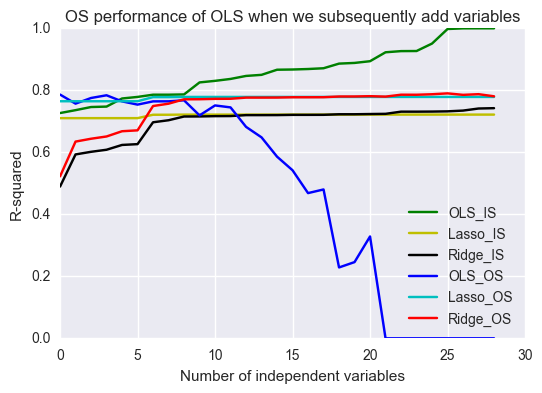

In [21]:
OLS_R_2_OS_F=[]
OLS_R_2_IS_F=[]
OLS_R_2_Ridge_OS_F=[]
OLS_R_2_Ridge_IS_F=[]
OLS_R_2_Lasso_OS_F=[]
OLS_R_2_Lasso_IS_F=[]

Ridge=linear_model.Ridge(fit_intercept=True,alpha=alpha_r_optimal)
Lasso=linear_model.Lasso(fit_intercept=True, alpha=alpha_l_optimal)

for j in Number_variables:
    # OLS
    lm = smf.ols(formula = 'Y ~ '+ '+'.join(data3.columns[:j+1]), 
                 data = pd.concat([X_train.ix[:,:j+1],y_train], axis = 1)).fit()
    error = lm.predict(X_test.ix[:,:j+1]) - y_test
    R_2_OS_OLS=1-error.var()/y_test.var()
    R_2_IS_OLS = lm.rsquared
    OLS_R_2_IS_F.append(R_2_IS_OLS)
    OLS_R_2_OS_F.append(max(R_2_OS_OLS,0))
    
    # Ridge
    Ridge.fit(X_train.ix[:,:j+1],y_train)
    
    # In sample:
    err_IS=Ridge.predict(X_train.ix[:,:j+1]) - y_train
    R_2_IS_Ridge=1-np.var(err_IS)/np.var(y_train)
    OLS_R_2_Ridge_IS_F.append(R_2_IS_Ridge)
    
    #Out of sample
    err_OS=Ridge.predict(X_test.ix[:,:j+1]) - y_test
    R_2_OS_Ridge=1-np.var(err_OS)/np.var(y_test)
    OLS_R_2_Ridge_OS_F.append(max(R_2_OS_Ridge,0))

    # Lasso
    
    Lasso.fit(X_train.ix[:,0:j+1],y_train)
    
    #In sample:
    p_IS=Lasso.predict(X_train.ix[:,0:j+1])
    err_IS=p_IS-y_train
    R_2_IS_Lasso=1-np.var(err_IS)/np.var(y_train)
    OLS_R_2_Lasso_IS_F.append(R_2_IS_Lasso)

    #Out of sample
    p_OS=Lasso.predict(X_test.ix[:,0:j+1])
    err_OS=p_OS-y_test
    R_2_OS_Lasso=1-np.var(err_OS)/np.var(y_test)
    OLS_R_2_Lasso_OS_F.append(max(R_2_OS_Lasso,0))

plt.title('OS performance of OLS when we subsequently add variables')

plt.plot(Number_variables,OLS_R_2_IS_F,'g',label='OLS_IS')
plt.plot(Number_variables,OLS_R_2_Lasso_IS_F,'y',label='Lasso_IS')
plt.plot(Number_variables,OLS_R_2_Ridge_IS_F,'k',label='Ridge_IS')

plt.plot(Number_variables,OLS_R_2_OS_F,'b',label='OLS_OS')
plt.plot(Number_variables,OLS_R_2_Lasso_OS_F,'c',label='Lasso_OS')
plt.plot(Number_variables,OLS_R_2_Ridge_OS_F,'r',label='Ridge_OS')

plt.legend(loc='lower right')
plt.xlabel('Number of independent variables')
plt.ylabel('R-squared')
plt.show()

#### Look at the coefficients of all three models (OLS, Ridge, Lasso) now.  

In [22]:
#let's look at the final coefficients
name=["var_{0}".format(i+1) for i in range(len(OLS_coef)-1)] # Generate name of rows/variables

result=[name, np.ndarray.tolist(np.asarray(OLS_coef[0:len(OLS_coef)-1])),np.ndarray.tolist(Ridge_coef),
        np.ndarray.tolist(Lasso_coef)] # put all the estimations of different models together(it is same for OS and IS)
temp=pd.DataFrame(result).T
R2_IS=pd.DataFrame(['R2_IS',R_2_IS_OLS, R_2_IS_Ridge,R_2_IS_Lasso]).T # paste the In sample R2 in the end of temp
R2_OS=pd.DataFrame(['R2_OS',R_2_OS_OLS, R_2_OS_Ridge,R_2_OS_Lasso]).T # paste the Out of sample R2 in the end of temp

temp=temp.append(R2_IS)
result=temp.append(R2_OS)
result.columns=['','OLS','Ridge','Lasso'] # Change the column name
result.set_index('')

,OLS,Ridge,Lasso
,,,
var_1,0.000175476,0.0332589,0
var_2,2.38419e-07,0.0293137,0
var_3,2.86102e-06,0.0106894,0
var_4,-4.76837e-07,0.00994482,0
var_5,-8.34465e-07,-0.0162779,-0
var_6,-2.86102e-06,0.00710685,0
var_7,-4.47035e-08,0.0576026,0
var_8,4.76837e-07,0.0310431,0
var_9,1.19209e-07,0.0602992,0.287472


#### Cross-validation. 
On such a small sample performance might largely depend on the split between training, validation and test sets. In order to verify that efficiency of Lasso and Ridge is not just a random consequence of a favorable split perform a cross-validation, reporting average IS/OS performance for each model averaged over 10 different random splits.